In [ ]:
import os
import numpy as np
import pandas as pd
import re
import time
import helper
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.metrics import accuracy_score

import torch
import torchvision
from torchvision.utils import make_grid
from torchvision import datasets, transforms
from torchvision.io import read_image
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import models
from PIL import Image,ImageDraw,ImageFont
from torch.optim import lr_scheduler


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
os.chdir('/content/drive/MyDrive')

Transfer learning by freezing last layer and fine tune parameters of pre trained  models. Resnet18 and Effiecientnet models are used below

In [ ]:
data_transforms={"train":transforms.Compose([transforms.RandomResizedCrop(224),
                    transforms.RandomHorizontalFlip(),
                    transforms.ToTensor(),
                    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
                    ]),
'val':transforms.Compose([transforms.Resize(256),
                    transforms.CenterCrop(224),
                    transforms.ToTensor(),
                    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
                    ])}

image_datasets = {x: datasets.ImageFolder(os.path.join('hymenoptera_data', x),data_transforms[x])for x in ['train', 'val']}
dataloader={x:torch.utils.data.DataLoader(image_datasets[x],batch_size=4,shuffle=True) for x in ['train', 'val'] }

dataset_size={x :len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes


print('class names {}'.format(len(dataloader['train'])))
print('{} batches in training'.format(len(dataloader['train'])))
print('{} batches in validation'.format(len(dataloader['val'])))
print('{} training images'.format(dataset_size['train']))
print('{} validation images'.format(dataset_size['val']))

class names 61
61 batches in training
39 batches in validation
244 training images
153 validation images


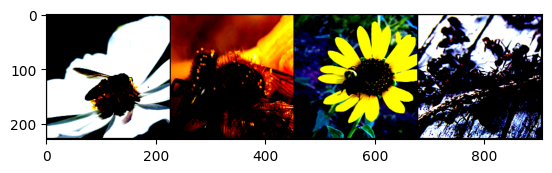

In [ ]:
inputs, classes = next(iter(dataloader['train']))
grid = make_grid(inputs)
plt.imshow(grid.permute(1, 2, 0))

In [37]:
model=torchvision.models.efficientnet_v2_m(pretrained=True)

for param in model.parameters():
  param.requires_grad=False

num_ftrs=model.classifier[1].in_features
model.classifier[1]=nn.Linear(num_ftrs,2)

criterion=nn.CrossEntropyLoss()
optimizer=optim.SGD(model.classifier[1].parameters(),lr=0.001,momentum=0.9)
exp_lr_scheduler=lr_scheduler.StepLR(optimizer,step_size=7,gamma=0.1)

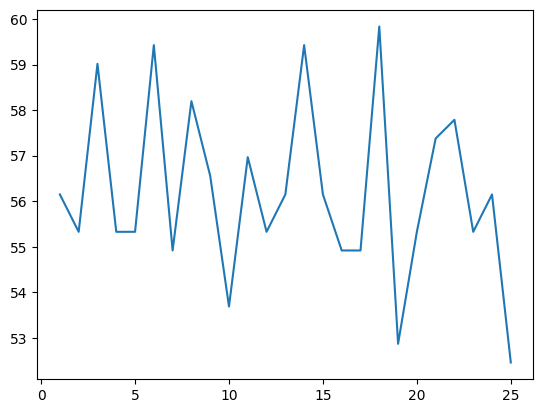

In [48]:
epochs=25
train_acc=[]
train_loss=[]
for e in range(epochs):
  # exp_lr_scheduler.step()
  correct=0
  for images,labels in dataloader['train']:
    optimizer.zero_grad()

    output=model(images)
    loss=criterion(output,labels)
    loss.backward()
    optimizer.step()
    exp_lr_scheduler.step()
    _,preds=torch.max(output,1)
    correct+=(preds==labels).sum().item()

  train_acc.append(100* correct/dataset_size['train'])
  train_loss.append(loss.item())

print('Loss {}, train Accuracy {}' .format(train_loss[-2:],train_acc[-2:]))
plt.plot(range(1,epochs+1),train_acc)

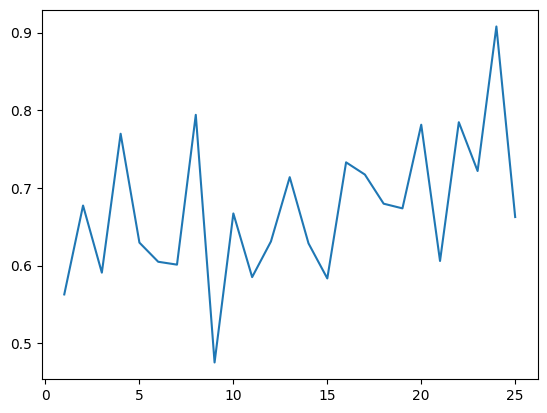

In [47]:
plt.plot(range(1,epochs+1),train_loss)

test Accuracy 65.359477124183
Validation loss 0.6709227854130315
100 153


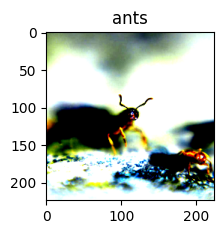

In [49]:
model.eval()
index=0
with torch.no_grad():
  correct=0
  total=0
  total_loss=0
  for images,labels in dataloader['val']:
    output=model(images)
    _,predicted=torch.max(output.data,1)
    total+=labels.size(0)
    correct+=(predicted==labels).sum().item()

    loss=criterion(output,labels)
    total_loss+=loss.item()*labels.size(0)
    avg_loss=total_loss/total

  print('test Accuracy {}' .format(100 * correct/ total))
  print('Validation loss {}'.format(avg_loss))
  print(correct,total)

  num_images_in_batch = images.shape[0]

  for i in range(min(5, num_images_in_batch)):
    index+=1
    ax=plt.subplot(2,2,index)
    ax.set_title('{}'.format(class_names[predicted[i]]))
    img=images.cpu().data[i].numpy()
    plt.imshow(img.transpose((1, 2, 0)))



## Remarks:
Efficientnet has high inference time compared to resnet with low performance

Resnet18 with SGD Optimiser at learning rate 0.001 and step size 7 is giving best results with less inference time compared to others